# Expedia Personalised Hotel Searches
VU Data Mining Techniques 2024 | Assignment 2 | Group 17

## Imports

In [1]:
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import zipfile
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler  # used instead of StandardScaler because our data is mostly not normally distributed
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)

## Setup & Data Loading

In [ ]:
def downscale_and_save(df, filename):
    df_copy = df.copy()

    for col in df_copy.select_dtypes(include='float64').columns:
        df_copy[col] = df_copy[col].astype('float32')

    df_copy.to_csv(filename, index=False)

    del df_copy
    gc.collect()

In [ ]:
train_path = 'data/training_set_VU_DM.csv'
test_path = 'data/test_set_VU_DM.csv'

In [ ]:
train_df = pd.read_csv(train_path)
train_df.head()

In [ ]:
test_df = pd.read_csv(test_path)
test_df.head()

In [ ]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col)

## EDA

In [ ]:
len(train_df)

In [ ]:
columns = list(train_df.columns)
columns.remove('date_time')

In [ ]:
for column in columns:
    plt.rcParams["figure.figsize"] = (20,3)
    sns.boxplot(train_df[column], orient='h')
    plt.title(column)
    plt.show()

In [ ]:
target_columns = ['click_bool', 'gross_bookings_usd', 'booking_bool']
for remove in target_columns:
    columns.remove(remove)

new_df = []
for column in columns:
    column_correlations = []
    for target in target_columns:
        column_correlations.append(train_df[column].corr(train_df[target]))
    new_df.append(column_correlations)
new_df = pd.DataFrame(new_df)
new_df.index = columns
new_df.columns = target_columns

In [ ]:
plt.rcParams["figure.figsize"] = (3,20)
sns.heatmap(new_df)

In [ ]:
grouped_by_position = train_df.groupby(['position'])

In [ ]:
top_40 = list(range(1,41))

In [ ]:
click_precent_top_40 = []
book_precent_top_40 = []
price_top_25 = []
for group in top_40:
    group_df = grouped_by_position.get_group(group)
    click_precent_top_40.append(group_df['click_bool'].sum()/len(group_df))
    book_precent_top_40.append(group_df['booking_bool'].sum()/len(group_df))
    price_top_25.append(group_df['price_usd'].mean()/group_df['srch_length_of_stay'].mean())
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(click_precent_top_40)
plt.plot(book_precent_top_40)
plt.xlabel('position')
plt.ylabel('probability')
plt.legend(["clicking", "booking"], loc="upper right")

In [ ]:
plt.plot(price_top_25)
plt.xlabel('position')
plt.ylabel('price per night')

Probability to be clicked/booked drops very quickly and stabelizes after position 10.

In [ ]:
competitive_metrics = ['compX_rate', 'compX_inv', "compX_rate_percent_diff"]
full_competitive_metrics = []
for metric in competitive_metrics:
    metric_list = []
    for x in range(1,9):
        metric_list.append(metric.replace("X", str(x)))
    full_competitive_metrics.append(metric_list)

In [ ]:
len(train_df[full_competitive_metrics[2]].dropna(axis = 'index', how = 'all'))

too much nan values

In [ ]:
len(train_df[full_competitive_metrics[1]].dropna(axis = 'index', how = 'all'))

feature not relevant enough.

In [ ]:
train_df['combined_comp_rate'] = train_df[full_competitive_metrics[0]].iloc[:, :].sum(axis=1)

In [ ]:
comp_rate_nan_index = train_df.index.difference(train_df[full_competitive_metrics[0]].dropna(axis = 'index', how = 'all').index)
train_df.loc[comp_rate_nan_index, 'combined_comp_rate'] = np.nan

In [ ]:
print(len(pd.unique(train_df['srch_id'])))
print(train_df['click_bool'].sum())
print(train_df['booking_bool'].sum())

On average more clicks than searches. On average less bookings than searches. Makes sense

In [ ]:
def plot_vars_dist(df):
    variables = [var for var in df if var not in ['srch_id','date_time']]  # ignoring these as they are only 1 value indicating occurence of a call/sms
    fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, 6 * len(variables)))

    for ax, var in zip(axes.flatten(), variables):
        var_data = df[var]
        mean = var_data.mean()
        std = var_data.std()
        # Adjust bins for better visualization based on data range and characteristics
        bins = min(30, int(var_data.nunique()))  # Use a minimum of 30 bins or less if fewer unique values

        ax.hist(var_data, bins=bins, alpha=0.75, color='blue', edgecolor='black', label=f'{var} Scores')
        ax.set_title(f'Distribution of {var} values')
        ax.set_xlabel(f'{var.capitalize()} Score')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.75)
        legend_label = f"Mean: {mean:.2f}, Std: {std:.2f}"
        ax.legend([f"{var.capitalize()} Scores\n{legend_label}"], loc='upper right', title='Statistics', frameon=True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_vars_dist(train_df)

In [ ]:
df_corr = train_df.drop(['srch_id','date_time'],axis = 1)

In [ ]:
df_corr.corr()

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

In [ ]:
train_df.isnull().sum()

## Data Preprocessing

### Dropping Features

In [ ]:
train_df.drop(['gross_bookings_usd'], axis=1, inplace=True)

### Datatype Conversion & Grouping Features

In [ ]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])

boolean_features = ['prop_brand_bool', 'promotion_flag', 'srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool']
for col in boolean_features:
    train_df[col] = train_df[col].astype('bool')
    
categorical_features = ['site_id', 'visitor_location_country_id', 'prop_country_id']  # 'srch_id', 'prop_id' and 'srch_destination_id' are not included because they are real identifiers rather than categorical features
for col in categorical_features:
    train_df[col] = train_df[col].astype('category')
    
numerical_features = [col for col in train_df.columns if col not in boolean_features + categorical_features + ['date_time', 'srch_id', 'prop_id', 'srch_destination_id']]
    
train_df.info()

In [ ]:
test_df['date_time'] = pd.to_datetime(test_df['date_time'])

for col in test_df.columns:
    if col in boolean_features:
        test_df[col] = test_df[col].astype('bool')
    elif col in categorical_features:
        test_df[col] = test_df[col].astype('category')

#### Handling DateTime Feature

In [ ]:
# Extract useful features from 'date_time'
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['day'] = train_df['date_time'].dt.day
train_df['hour'] = train_df['date_time'].dt.hour
train_df['minute'] = train_df['date_time'].dt.minute

test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['day'] = test_df['date_time'].dt.day
test_df['hour'] = test_df['date_time'].dt.hour
test_df['minute'] = test_df['date_time'].dt.minute

# Drop the original 'date_time' column
train_df = train_df.drop(columns=['date_time'])
test_df = test_df.drop(columns=['date_time'])

### Removing Outliers for Numerical Features

In [ ]:
num_feats_with_outliers = ['price_usd', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']

for feature in num_feats_with_outliers:  # Based on EDA only price_usd & compX_rate_percent_diff
    # Print initial statistics
    print(f'Initial stats for {feature}:')
    print(train_df[feature].describe())

    # Calculating IQR
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Replace outliers with NaN
    train_df.loc[~train_df[feature].between(lower_bound, upper_bound), feature] = np.nan

In [ ]:
train_df.head()

### Imputing Missing Values for Numerical Features

Zero was chosen as the imputation value for the numerical features because it intuitively denotes a missing record, for the competitor data where we have either +1, 0, -1, assuming 0 in the case of missing data assumes no advantage for Expedia or a competitor.

In [ ]:
print('Missing values replaced with 0:')
print('------------------------------')
for feature in numerical_features:
    print(f'{feature} - {train_df[feature].isna().sum()}')
    train_df.fillna({feature: 0}, inplace=True)

In [ ]:
train_df.head()

In [ ]:
print('Missing values replaced with 0:')
print('------------------------------')
for feature in numerical_features:
    if feature in test_df.columns:
        print(f'{feature} - {test_df[feature].isna().sum()}')
        test_df.fillna({feature: 0}, inplace=True)

### Computing EXP Features for Categorical Features

EXP features involve calculating the probability of a target variable (booking & click in our case) given a certain categorical feature. This is done by grouping the data by the categorical feature and calculating the mean of the booking/click_bool column. This is then merged back into the original dataframe to create the new feature that is in numerical space.

In [ ]:
for feature in categorical_features:
    # Initialize new columns for EXP features
    train_df[f'{feature}_exp_click'] = np.nan
    train_df[f'{feature}_exp_booking'] = np.nan
    
    # Iterate over each category in the feature
    for category in train_df[feature].unique():
        # Create mask for the current category
        category_mask = train_df[feature] == category
        
        # Calculate sums and counts excluding the current row
        # We use sum and count to calculate the mean without the current row
        sum_click = train_df.loc[category_mask, 'click_bool'].sum()
        count_click = category_mask.sum()
        sum_booking = train_df.loc[category_mask, 'booking_bool'].sum()
        count_booking = category_mask.sum()
        
        # Assign the leave-one-out mean to the rows of the current category
        # For each row, we use (sum - current value) / (count - 1) to get the leave-one-out mean
        # Important to leave out the current row when calculating the mean to prevent data leakage
        train_df.loc[category_mask, f'{feature}_exp_click'] = (sum_click - train_df['click_bool']) / (count_click - 1)
        train_df.loc[category_mask, f'{feature}_exp_booking'] = (sum_booking - train_df['booking_bool']) / (count_booking - 1)

# Handle cases where the category only has one row and thus (count - 1) would be zero
for feature in categorical_features:
    train_df.fillna({f'{feature}_exp_click': train_df['click_bool'].mean()}, inplace=True)
    train_df.fillna({f'{feature}_exp_booking': train_df['booking_bool'].mean()}, inplace=True)

In [ ]:
train_df.head()

In [ ]:
# Computing EXP features for test set
for feature in categorical_features:
    mean_click = train_df.groupby(feature)['click_bool'].mean()
    mean_booking = train_df.groupby(feature)['booking_bool'].mean()
    
    test_df[f'{feature}_exp_click'] = test_df[feature].map(mean_click)
    test_df[f'{feature}_exp_booking'] = test_df[feature].map(mean_booking)

### Feature Engineering

#### 'Proxy' Prior for Property Position in Results

In [ ]:
filtered_df = train_df[train_df['random_bool'] == False]  #? Exclude records where the results order is random
mean_positions = filtered_df.groupby('prop_id')['position'].mean().rename('mean_position')
train_df = train_df.join(mean_positions, on='prop_id')

In [ ]:
train_df.head()

In [ ]:
# Proxy prior for property position in search results in test set based on training set
test_df = test_df.join(mean_positions, on='prop_id')

#### Prior of Booking/Clicks per Property

In [ ]:
def compute_prior(df, group_field, value_field):
    # Sum and count values per group
    sums = df.groupby(group_field)[value_field].transform('sum')
    count = df.groupby(group_field)[value_field].transform('count')
    
    # Calculate leave-one-out prior
    prior = (sums - df[value_field]) / (count - 1)
    return prior

In [ ]:
# Apply function for click and booking bool
train_df['click_prior'] = compute_prior(train_df, 'prop_id', 'click_bool')
train_df['booking_prior'] = compute_prior(train_df, 'prop_id', 'booking_bool')

# Handling cases with only one record per group
train_df.fillna({'click_prior': train_df['click_bool'].mean()}, inplace=True)
train_df.fillna({'booking_prior': train_df['booking_bool'].mean()}, inplace=True)

In [ ]:
train_df.head()

In [ ]:
# Priors for click and booking bool
test_df['click_prior'] = test_df['prop_id'].map(train_df.groupby('prop_id')['click_bool'].mean())
test_df['booking_prior'] = test_df['prop_id'].map(train_df.groupby('prop_id')['booking_bool'].mean())

# Handling cases with only one record per group @Lieve - method used here is mean not 0, important for report!!! :)
test_df.fillna({'click_prior': train_df['click_bool'].mean()}, inplace=True)
test_df.fillna({'booking_prior': train_df['booking_bool'].mean()}, inplace=True)

#### Number of Previous Search Resutls Containing the Property

In [ ]:
# Number of occurences "minus the current row"
train_df['previous_searches'] = train_df.groupby('prop_id')['prop_id'].transform('count') - 1

In [ ]:
train_df.head()

In [ ]:
# Number of occurences "minus the current row"
test_df['previous_searches'] = test_df['prop_id'].map(train_df.value_counts('prop_id') - 1).fillna(0)

#### Saving Intermediate Dataset

In [ ]:
downscale_and_save(train_df, 'data/processed_train.csv')

In [ ]:
downscale_and_save(test_df, 'data/processed_test.csv')

#### Statistical Features for Each Property

Mean, median & std for selected features across all instances of each property

In [ ]:
features_to_stat = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'orig_destination_distance', 'srch_query_affinity_score', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count']  # Perhaps change this based on LightGBM.feature_importances_

for feature in tqdm(features_to_stat):
    stats = train_df.groupby('prop_id')[feature].agg(['min', 'max', 'mean', 'median', 'std']).rename(
        columns={'min': f'{feature}_min', 'max': f'{feature}_max', 'mean': f'{feature}_mean', 'median': f'{feature}_median', 'std': f'{feature}_std'})
    train_df = train_df.join(stats, on='prop_id')

In [ ]:
train_df.head()

In [ ]:
for feature in tqdm(features_to_stat):
    stats = train_df.groupby('prop_id')[feature].agg(['min', 'max', 'mean', 'median', 'std']).rename(
        columns={'min': f'{feature}_min', 'max': f'{feature}_max', 'mean': f'{feature}_mean', 'median': f'{feature}_median', 'std': f'{feature}_std'})
    test_df = test_df.join(stats, on='prop_id')

### Saving Intermediate Data

In [ ]:
downscale_and_save(train_df, 'data/processed_train_stats.csv')

In [ ]:
downscale_and_save(test_df, 'data/processed_test_stats.csv')

### Normalising Features

In [ ]:
test_df.head()

In [ ]:
float_columns = [col for col in train_df.select_dtypes(include='float64').columns if col in test_df.columns]

scaler = MinMaxScaler()

train_df[float_columns] = scaler.fit_transform(train_df[float_columns])

test_df[float_columns] = scaler.transform(test_df[float_columns])

### Saving Final Data

In [ ]:
downscale_and_save(train_df, 'data/processed_train_stats_norm.csv')

In [ ]:
downscale_and_save(test_df, 'data/processed_test_stats_norm.csv')

In [ ]:
del train_df, test_df
gc.collect()

## Modeling

### Preparing the Data for Modeling

In [2]:
train_df = pd.read_csv('data/processed_train_stats_norm.csv')

In [3]:
test_df = pd.read_csv('data/processed_test_stats_norm.csv')

In [4]:
missing_feats = set(train_df.columns) - set(test_df.columns)
print(f'Missing features in test set: {missing_feats}')

Missing features in test set: {'combined_comp_rate', 'click_bool', 'position', 'booking_bool'}


In [5]:
features = train_df.drop(columns=list(missing_feats))
target = train_df['booking_bool']

X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

Training set shape: (3966677, 139) | (3966677,)
Validation set shape: (991670, 139) | (991670,)


In [6]:
# Create query groups
train_group = X_train.groupby('srch_id').size().values
val_group = X_val.groupby('srch_id').size().values

X_train.drop(columns=['srch_id'], axis=1, inplace=True)
X_val.drop(columns=['srch_id'], axis=1, inplace=True)

print(f'Training set shape: {X_train.shape} | {y_train.shape}\nValidation set shape: {X_val.shape} | {y_val.shape}')

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train, group=train_group)
val_data = lgb.Dataset(X_val, label=y_val, group=val_group, reference=train_data)

### LambdaMART Model Training

In [7]:
param_grid = {
    'num_leaves': [10, 20, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

best_score = -float('inf')
best_params = {}

# Iterate over all combinations of parameters
for params in tqdm(ParameterGrid(param_grid)):
    model = lgb.LGBMRanker(
        objective="lambdarank",
        boosting_type="gbdt",
        importance_type="gain",
        metric="ndcg",
        label_gain=[i for i in range(max(y_train.max(), y_val.max()) + 1)],
        **params
    )
    model.fit(
        X_train,
        y_train,
        group=train_group,
        eval_set=[(X_val, y_val)],
        eval_group=[val_group],
        eval_at=[5],
    )
    
    # Evaluate the model
    y_pred_val = model.predict(X_val)
    score = ndcg_score([y_val], [y_pred_val], k=5)

    # Save the best model
    if score > best_score:
        best_score = score
        best_params = params
        model.booster_.save_model('best_lambdamart_model.txt')


print('-' * 50)
print(f'Best NDCG Score: {best_score}')
print(f'Best Parameters: {best_params}')

  0%|          | 0/18 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.795288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


  6%|▌         | 1/18 [01:14<21:11, 74.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.718701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 11%|█         | 2/18 [02:38<21:20, 80.01s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.676199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 17%|█▋        | 3/18 [04:02<20:26, 81.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.772757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 22%|██▏       | 4/18 [05:48<21:17, 91.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.736788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 28%|██▊       | 5/18 [07:51<22:15, 102.73s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.063178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 33%|███▎      | 6/18 [10:10<23:03, 115.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.838373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 39%|███▉      | 7/18 [11:38<19:29, 106.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.891368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 44%|████▍     | 8/18 [12:56<16:12, 97.25s/it] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.028777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 50%|█████     | 9/18 [14:26<14:15, 95.07s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.068694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 56%|█████▌    | 10/18 [16:17<13:20, 100.03s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.579177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 61%|██████    | 11/18 [18:47<13:25, 115.14s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.885769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 67%|██████▋   | 12/18 [20:57<11:57, 119.58s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.582094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 72%|███████▏  | 13/18 [22:15<08:55, 107.02s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.808979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 78%|███████▊  | 14/18 [23:38<06:38, 99.71s/it] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.697021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 83%|████████▎ | 15/18 [25:02<04:44, 94.99s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.717180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 89%|████████▉ | 16/18 [26:49<03:17, 98.79s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.693116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138


 94%|█████████▍| 17/18 [28:48<01:44, 104.94s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.904990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17406
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

100%|██████████| 18/18 [30:49<00:00, 102.76s/it]

--------------------------------------------------
Best NDCG Score: 0.9999999999999999
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 20}


### Showing Feature Importances

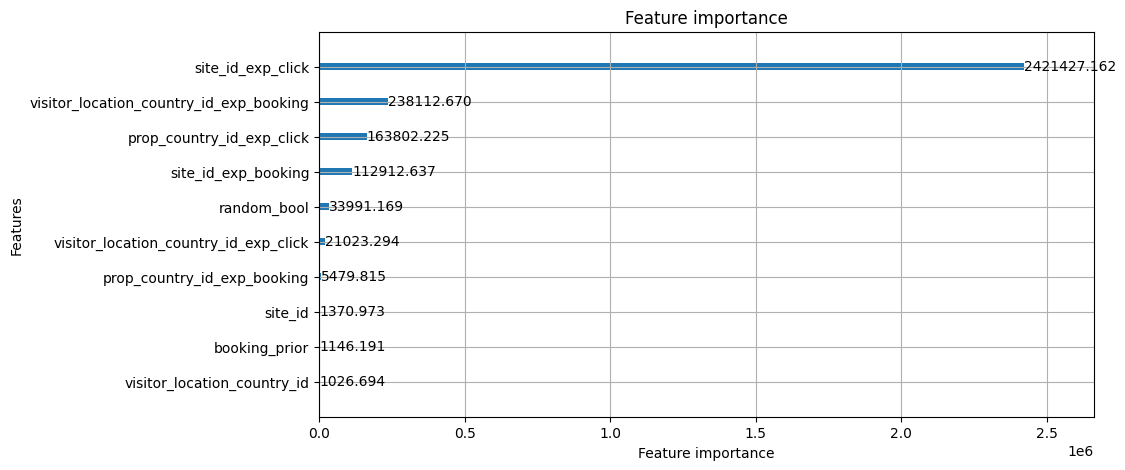

In [8]:
lgb.plot_importance(model, importance_type='gain', max_num_features=10, figsize=(10, 5))

# Store feature importances in a txt file
with open('feature_importances.txt', 'w') as f:
    f.write(str(model.feature_importances_))

## Final Prediction

In [9]:
# Load the test data
X_test = test_df.drop(columns=['srch_id'])
assert len(X_train.columns) == len(X_test.columns), 'Training and test set have different number of features'

# Load the model
best_model = lgb.Booster(model_file='best_lambdamart_model.txt')

# Predict on the test set
y_pred = best_model.predict(X_test)

# Add predictions to the test set
test_df['predicted_score'] = y_pred

# Select only the required columns
test_df = test_df[['srch_id', 'prop_id', 'predicted_score']]

# Sort properties for each search by predicted score
test_df = test_df.sort_values(by=['srch_id', 'predicted_score'], ascending=[True, False])

# Create the submission file in the required format
submission = test_df[['srch_id', 'prop_id']]
submission.to_csv('submission.csv', index=False)

# Verify the submission file format
print(submission.head(5))
print(f'Submission shape: {submission.shape}')

# Zip the submission file
with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('submission.csv', compress_type=zipfile.ZIP_DEFLATED)

   srch_id  prop_id
0        1     3180
1        1     5543
2        1    14142
3        1    22393
4        1    24194
Submission shape: (4959183, 2)
